In [ ]:
#!pip install sentencepiece datasets transformers
!pip install transformers[sentencepiece] datasets

In [ ]:
from PIL import Image
import urllib.request
from io import BytesIO
import re

import torch

image_url = 'https://raw.githubusercontent.com/katanaml/sparrow/main/sparrow-data/docs/input/invoices/processed/images/invoice_10.jpg'

with urllib.request.urlopen(image_url) as url:
    image = Image.open(BytesIO(url.read()))

# image.show()

In [ ]:
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch

In [ ]:
#from transformers import DonutProcessor, VisionEncoderDecoderModel

#"naver-clova-ix/donut-base"
#"katanaml-org/invoices-donut-model-v1"
#"naver-clova-ix/donut-base-finetuned-cord-v2"
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
def process_document(image):
    # prepare encoder inputs
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # prepare decoder inputs
    task_prompt = "<s_cord-v2>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # generate answer
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=False,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=2,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # postprocess
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token

    return processor.token2json(sequence)

In [ ]:
result = process_document(image)
print(result)

{'menu': [{'nm': 'Invoice no: 49565075', 'unitprice': '10/28/2019', 'cnt': {'nm': 'Kane-Morgan Garcial Inc'}, 'price': 'Viaduct Suite 454'}, {'nm': 'Bernardville, VA 28211', 'cnt': '1', 'price': '3282'}, {'nm': 'BBAN: GB73WCI)55232646970614', 'unitprice': '909-75-542', 'cnt': '1', 'price': 'ITEMS'}, {'nm': 'No. Description Qty UM Net price Network NAT [%) Gross worth', 'unitprice': '3,000', 'cnt': '1', 'price': '59,94'}, {'nm': 'Swan Decative Metal Bottle', 'unitprice': '59,94', 'cnt': '1', 'price': '65,93'}, {'nm': 'Stoppe Wine Saver', 'unitprice': [{'cnt': '2', 'price': '8,80'}, {'nm': 'Glass 15 Once GLS1-5534H'}], 'cnt': '3', 'price': '8,79'}, {'nm': 'Lalite Congratulations Hand', 'unitprice': '20,000', 'cnt': '3', 'price': '20.00'}, {'nm': 'Planet and decorated Wine', 'unitprice': '20,000', 'cnt': '3', 'price': '22.00'}], 'sub_total': {'subtotal_price': '87,94', 'tax_price': '8.79'}, 'total': {'total_price': '$ 96,73', 'creditcardprice': '87,94'}}


In [ ]:
image = Image.open("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")
image.show()

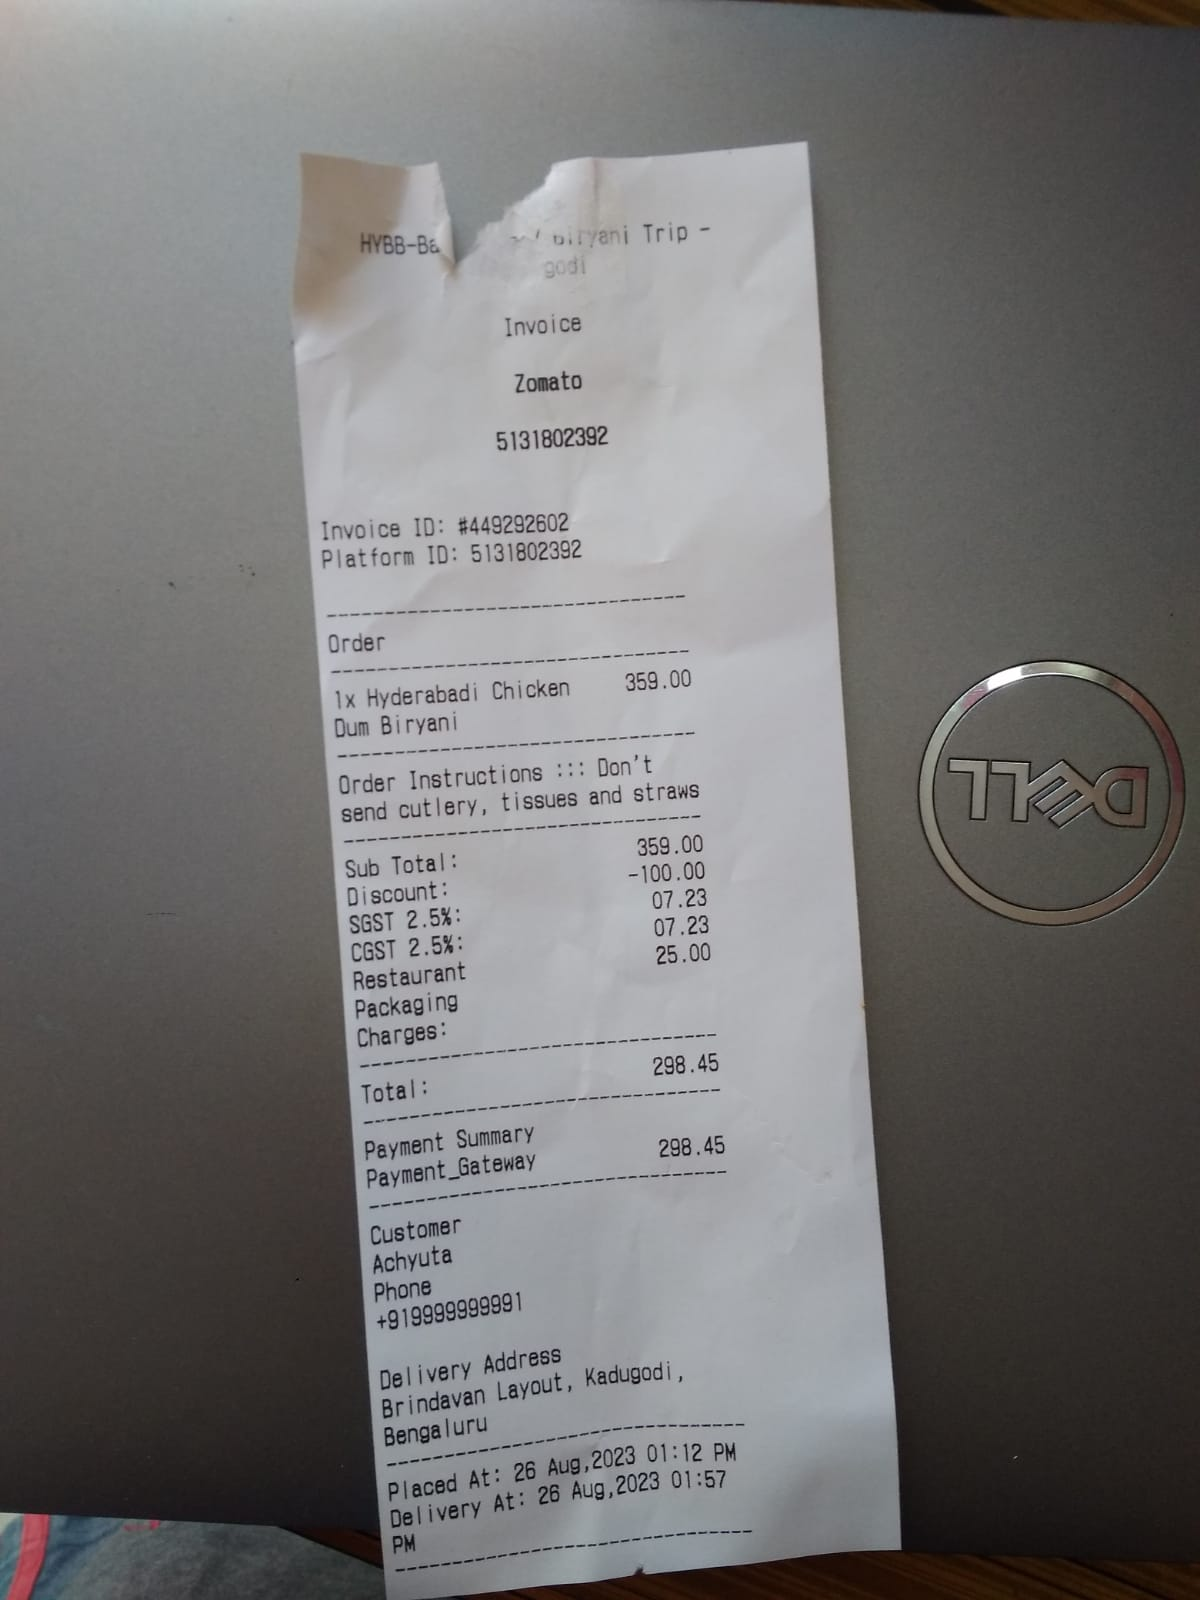

In [ ]:
image

In [ ]:
result = process_document(image)
print(result)

{'menu': [{'nm': 'HYBB-B6', 'cnt': '5131802392', 'discountprice': 'Zomato', 'price': {'unitprice': '#44928260', 'cnt': '1x', 'discountprice': '5131802392'}}, {'nm': 'Dum Biryani', 'cnt': '1x', 'discountprice': '359.00', 'price': '07.23'}, {'nm': 'Sub Total:', 'unitprice': '359.00', 'cnt': '2 x', 'discountprice': '-100.00', 'price': '07.23'}, {'nm': 'CGSTZ 2.5%:', 'price': '07.23'}], 'sub_total': {'subtotal_price': '25.00', 'tax_price': '298.45', 'etc': '298.45'}, 'total': {'total_price': '298.45', 'emoneyprice': '298.45'}}


# Visual Q&A

In [ ]:
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel
from datasets import load_dataset
import torch
#naver-clova-ix/donut-base-finetuned-cord-v2
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# load document image from the DocVQA dataset
#dataset = load_dataset("hf-internal-testing/example-documents", split="test")
#image = dataset[0]["image"]

def vqa_processor(image,question):
  # prepare decoder inputs
  task_prompt = "<s_docvqa><s_question>{user_input}</s_question><s_answer>"
  #question = "When is the coffee break?"
  prompt = task_prompt.replace("{user_input}", question)
  decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids

  pixel_values = processor(image, return_tensors="pt").pixel_values

  outputs = model.generate(
      pixel_values.to(device),
      decoder_input_ids=decoder_input_ids.to(device),
      max_length=model.decoder.config.max_position_embeddings,
      pad_token_id=processor.tokenizer.pad_token_id,
      eos_token_id=processor.tokenizer.eos_token_id,
      use_cache=True,
      bad_words_ids=[[processor.tokenizer.unk_token_id]],
      return_dict_in_generate=True,
  )

  sequence = processor.batch_decode(outputs.sequences)[0]
  sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
  print(processor.token2json(sequence))


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


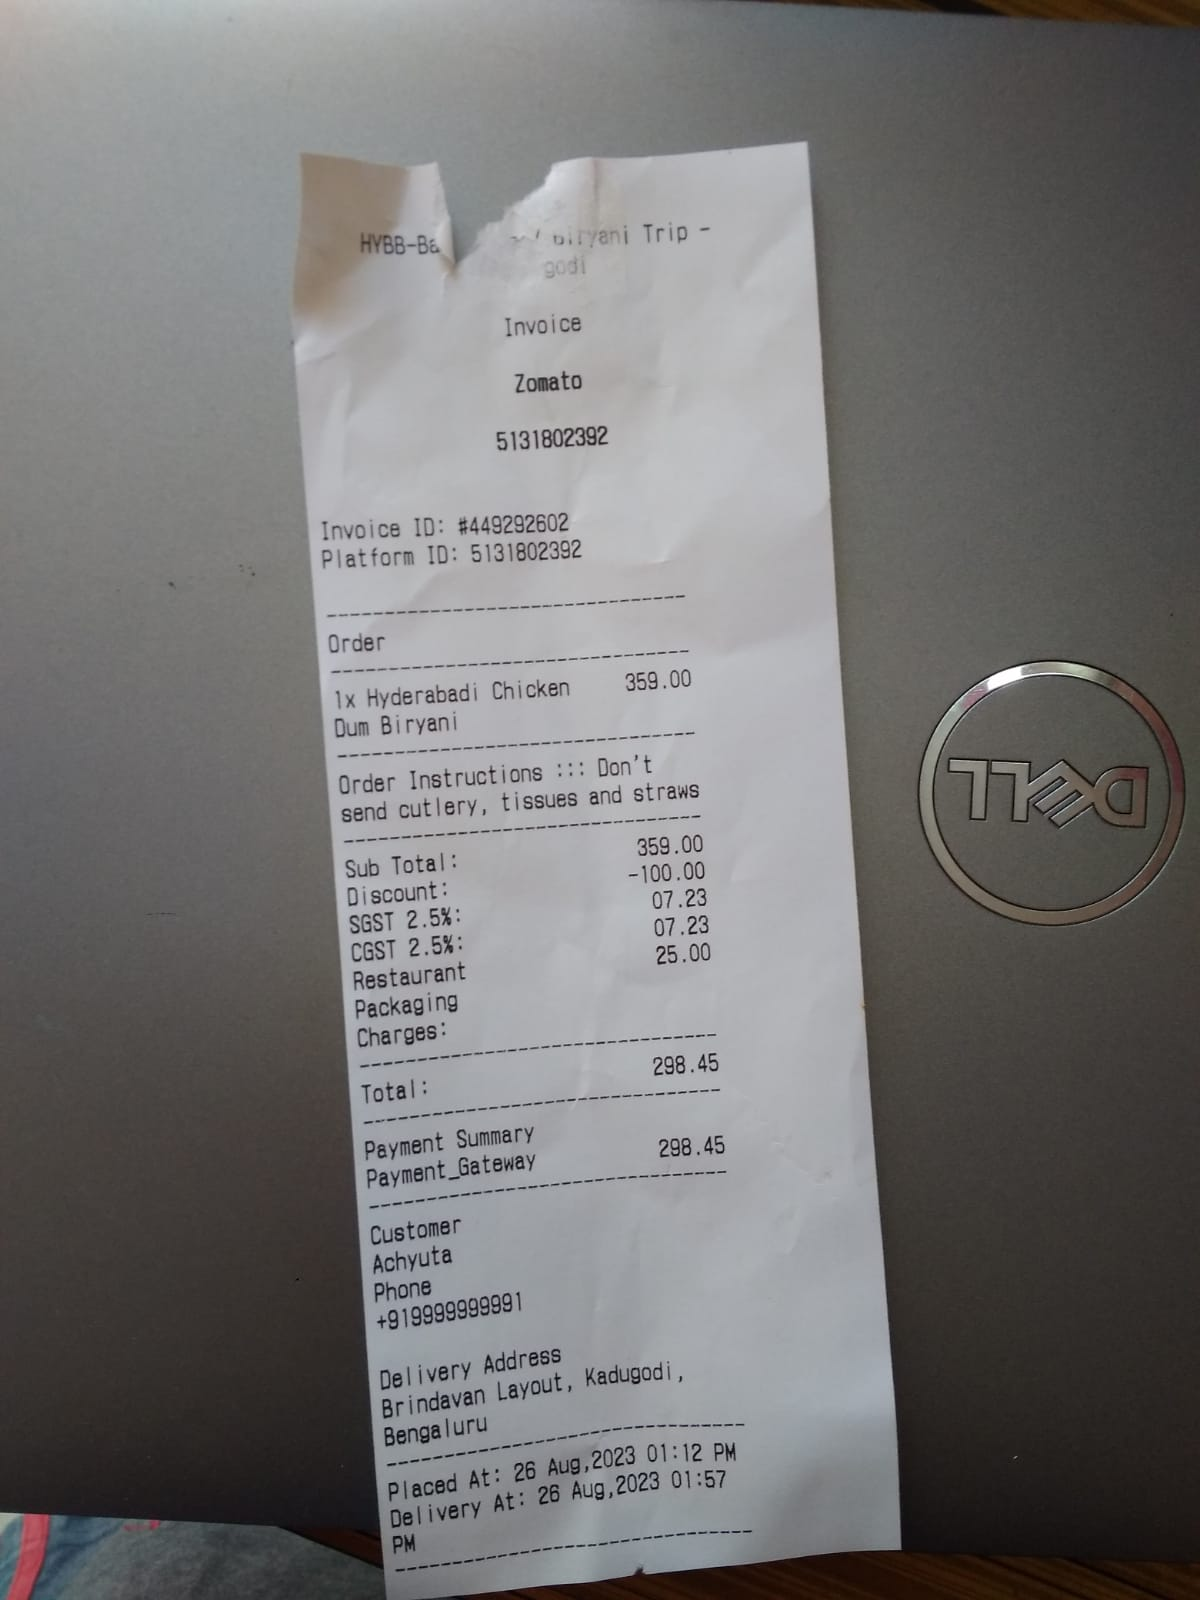

In [ ]:
image = Image.open("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")
image

In [ ]:
print(vqa_processor(image,"what is the invoice number ?"))

{'question': 'what is the invoice number?', 'answer': '#449292602'}
None


In [ ]:
print(vqa_processor(image,"what is the total cost ?"))

{'question': 'what is the total cost?', 'answer': '298.45'}
None


In [ ]:
print(vqa_processor(image,"what is the total amount ?"))

{'question': 'what is the total amount?', 'answer': '298.45'}
None


In [ ]:
print(vqa_processor(image,"what is customer name ?"))

{'question': 'what is customer name?', 'answer': 'achyuta'}
None


In [ ]:
print(vqa_processor(image,"what is the order date ?"))

{'question': 'what is the order time?', 'answer': '359.00'}
None


In [ ]:
print(vqa_processor(image,"what is the gst amount ?"))

{'question': 'what is the gst amount?', 'answer': '07.23'}
None


docTR

In [ ]:
!pip install rapidfuzz==2.15.1
!pip install "python-doctr[tf]"
#!pip install "python-doctr[torch]"
!pip install python-doctr

In [ ]:
from doctr.models import ocr_predictor#, kie_predictor

model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True,export_as_straight_boxes=True)
#model = kie_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True,export_as_straight_boxes=True)
#from doctr.models import linknet_resnet18_rotation
#model = linknet_resnet18_rotation(pretrained=True)

ImportError: ignored

In [ ]:
from doctr.io import DocumentFile
# PDF
#pdf_doc = DocumentFile.from_pdf("path/to/your/doc.pdf")
# Image
single_img_doc = DocumentFile.from_images("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")

In [ ]:
result = model(single_img_doc)

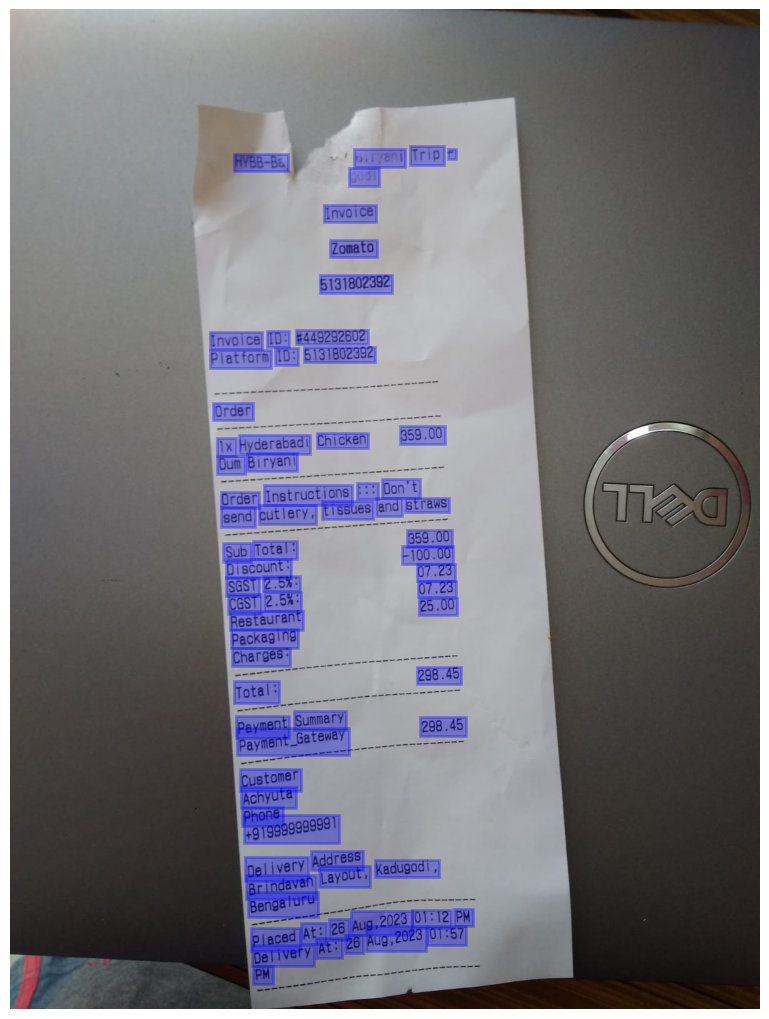

In [ ]:
result.show(single_img_doc)

In [ ]:
result

Document(
  (pages): [Page(
    dimensions=(1600, 1200)
    (blocks): [
      Block(
        (lines): [Line(
          (words): [Word(value='HYBB-Ba', confidence=0.38)]
        )]
        (artefacts): []
      ),
      Block(
        (lines): [
          Line(
            (words): [
              Word(value='biryani', confidence=0.84),
              Word(value='Trip', confidence=0.99),
              Word(value='-', confidence=1.0),
            ]
          ),
          Line(
            (words): [Word(value='godi', confidence=0.99)]
          ),
          Line(
            (words): [Word(value='Invoice', confidence=1.0)]
          ),
          Line(
            (words): [Word(value='Zomato', confidence=1.0)]
          ),
          Line(
            (words): [Word(value='5131802392', confidence=1.0)]
          ),
        ]
        (artefacts): []
      ),
      Block(
        (lines): [
          Line(
            (words): [
              Word(value='Invoice', confidence=1.0),
          

# Paddle OCR

In [ ]:
!pip install paddleocr --upgrade
!pip install paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.1/466.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 116.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 47101, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 47101 (delta 200), reused 232 (delta 128), pack-reused 46756
Receiving objects: 100% (47101/47101), 343.34 MiB | 25.30 MiB/s, done.
Resolving deltas: 100% (33050/33050), done.
Updating files: 100% (1889/1889), done.


In [ ]:
!wget http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
!sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb

--2023-08-26 11:29:34--  http://nz2.archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb
Resolving nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)... 91.189.91.82, 91.189.91.81, 185.125.190.39, ...
Connecting to nz2.archive.ubuntu.com (nz2.archive.ubuntu.com)|91.189.91.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1321244 (1.3M) [application/vnd.debian.binary-package]
Saving to: ‘libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb’

libssl1.1_1.1.1f-1u 100%[===================>]   1.26M  2.78MB/s    in 0.5s    

2023-08-26 11:29:34 (2.78 MB/s) - ‘libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb’ saved [1321244/1321244]

Selecting previously unselected package libssl1.1:amd64.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack libssl1.1_1.1.1f-1ubuntu2.19_amd64.deb ...
Unpacking libssl1.1:amd64 (1.1.1f-1ubuntu2.19) ...
Setting up libssl1.1:amd64 (1.1.1f-1ubuntu2.19) ...
debconf: unable to initialize fronten

In [ ]:
%cd PaddleOCR/ppstructure

# download model
!mkdir inference
%cd inference
# Download the detection model of the ultra-lightweight table English OCR model and unzip it
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/table/en_ppocr_mobile_v2.0_table_det_infer.tar && tar xf en_ppocr_mobile_v2.0_table_det_infer.tar
# Download the recognition model of the ultra-lightweight table English OCR model and unzip it
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/table/en_ppocr_mobile_v2.0_table_rec_infer.tar && tar xf en_ppocr_mobile_v2.0_table_rec_infer.tar
# Download the ultra-lightweight English table inch model and unzip it
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/table/en_ppocr_mobile_v2.0_table_structure_infer.tar && tar xf en_ppocr_mobile_v2.0_table_structure_infer.tar

##New OCR Model
#!wget https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar && tar xf en_PP-OCRv3_det_infer.tar


/content/PaddleOCR/ppstructure
/content/PaddleOCR/ppstructure/inference
--2023-08-26 11:20:27--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/table/en_ppocr_mobile_v2.0_table_det_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 124.237.208.76, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|124.237.208.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5001216 (4.8M) [application/x-tar]
Saving to: ‘en_ppocr_mobile_v2.0_table_det_infer.tar’

en_ppocr_mobile_v2. 100%[===================>]   4.77M  2.74MB/s    in 1.7s    

2023-08-26 11:20:30 (2.74 MB/s) - ‘en_ppocr_mobile_v2.0_table_det_infer.tar’ saved [5001216/5001216]

--2023-08-26 11:20:30--  https://paddleocr.bj.bcebos.com/dygraph_v2.0/table/en_ppocr_mobile_v2.0_table_rec_infer.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 124.237.208.76, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (p

In [ ]:
#%cd PaddleOCR/ppstructure
#!python3 /content/PaddleOCR/ppstructure/table/predict_table.py --det_model_dir=inference/en_PP-OCRv3_det_infer --rec_model_dir=inference/en_ppocr_mobile_v2.0_table_rec_infer --table_model_dir=inference/en_ppocr_mobile_v2.0_table_structure_infer --image_dir=/content/PaddleOCR/ppstructure/table_2.png --rec_char_dict_path=../ppocr/utils/dict/table_dict.txt --table_char_dict_path=../ppocr/utils/dict/table_structure_dict.txt --det_limit_side_len=736 --det_limit_type=min --output ./output/table

In [ ]:
from paddleocr import PaddleOCR,draw_ocr
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
ocr = PaddleOCR(use_angle_cls=True)

download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_det_infer.tar to /root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer/ch_PP-OCRv4_det_infer.tar


100%|██████████| 4.89M/4.89M [00:08<00:00, 608kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer/ch_PP-OCRv4_rec_infer.tar


100%|██████████| 11.0M/11.0M [00:07<00:00, 1.46MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:10<00:00, 208kiB/s]

[2023/08/26 11:30:22] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/ch/ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

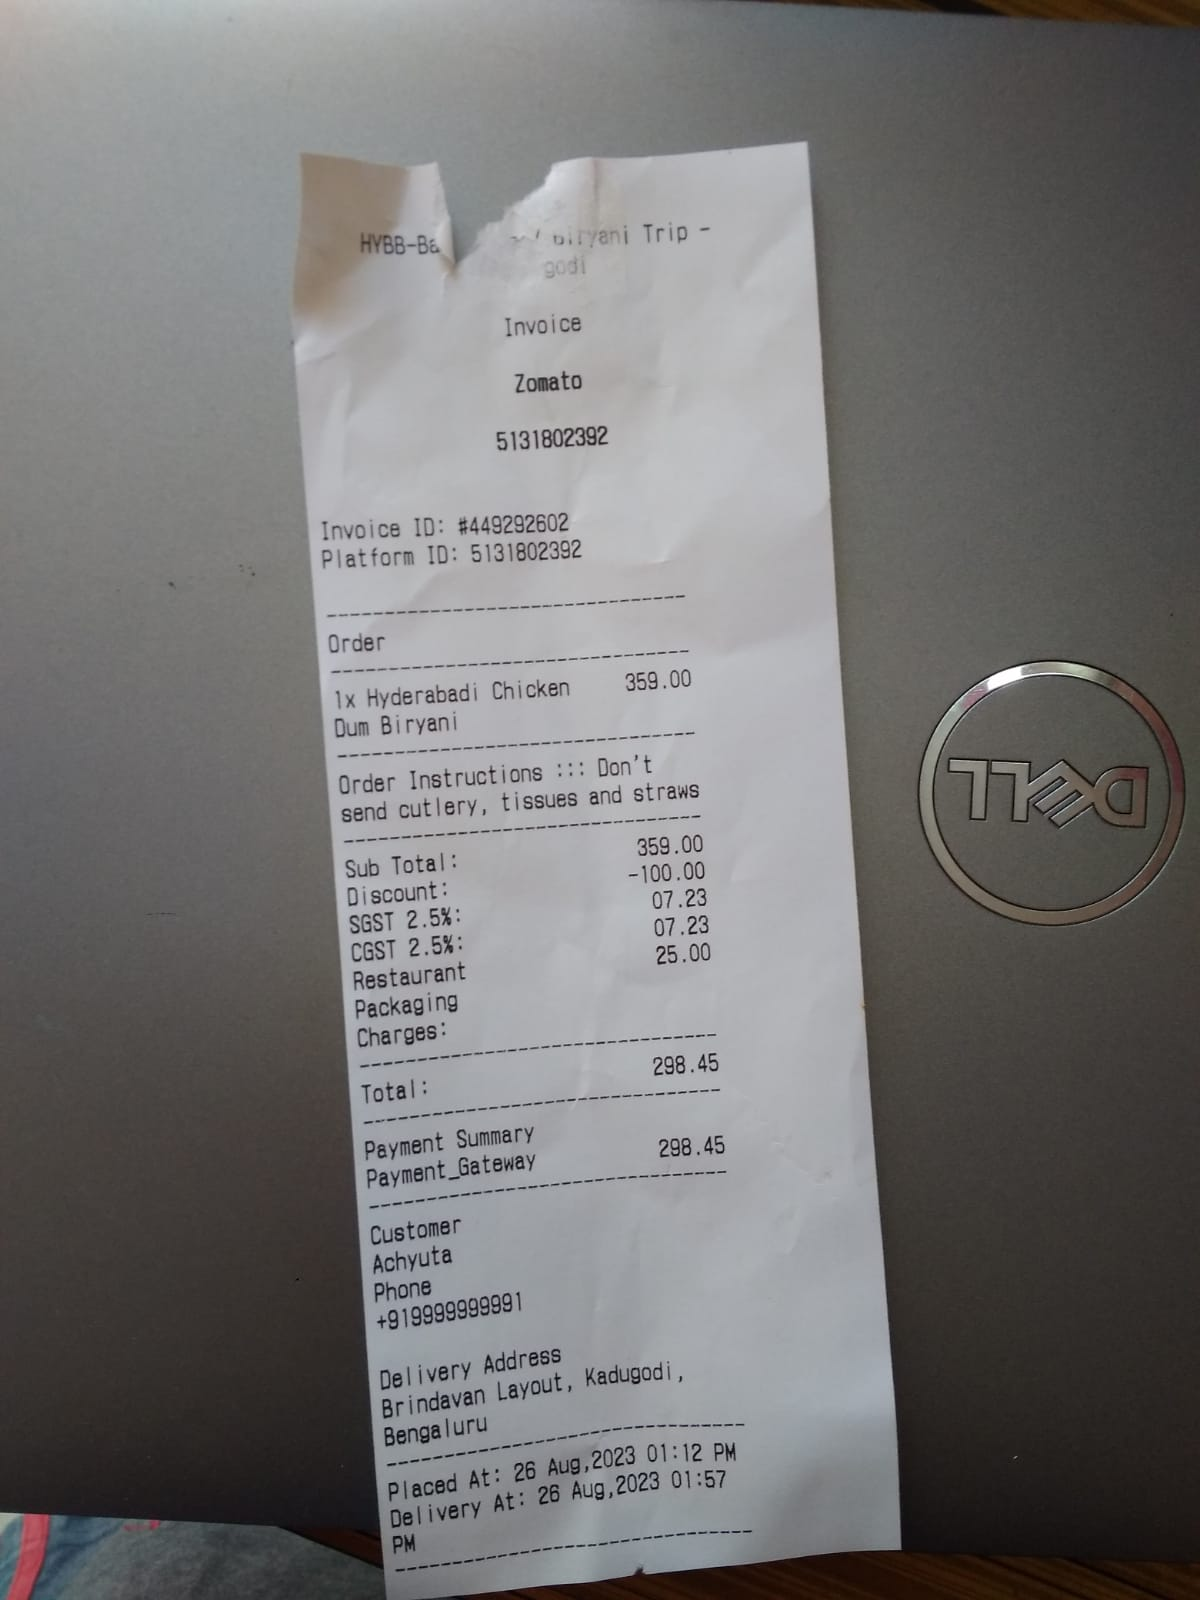

In [ ]:
from PIL import Image
image = Image.open("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")
image

In [ ]:

result = ocr.ocr("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")

[2023/08/26 11:31:46] ppocr DEBUG: dt_boxes num : 41, elapse : 1.5565917491912842
[2023/08/26 11:31:47] ppocr DEBUG: cls num  : 41, elapse : 0.5337347984313965
[2023/08/26 11:31:58] ppocr DEBUG: rec_res num  : 41, elapse : 11.285521030426025


In [ ]:
result

[[[[[356.0, 226.0], [447.0, 230.0], [446.0, 260.0], [354.0, 256.0]],
   ('HYBB-Ba', 0.9744095206260681)],
  [[[507.0, 225.0], [711.0, 215.0], [713.0, 245.0], [509.0, 255.0]],
   ('oiryani Trip-', 0.8884145021438599)],
  [[[536.0, 252.0], [589.0, 247.0], [592.0, 281.0], [539.0, 286.0]],
   ('godi', 0.8146436214447021)],
  [[[499.0, 312.0], [585.0, 308.0], [587.0, 340.0], [501.0, 344.0]],
   ('Invoice', 0.9935884475708008)],
  [[[507.0, 367.0], [585.0, 363.0], [587.0, 395.0], [509.0, 399.0]],
   ('Zomato', 0.9880671501159668)],
  [[[490.0, 427.0], [611.0, 419.0], [613.0, 450.0], [492.0, 457.0]],
   ('5131802392', 0.9978388547897339)],
  [[[317.0, 517.0], [572.0, 506.0], [573.0, 535.0], [318.0, 545.0]],
   ('Invoice ID:#449292602', 0.9698910713195801)],
  [[[315.0, 545.0], [584.0, 535.0], [585.0, 563.0], [316.0, 574.0]],
   ('Platform ID:5131802392', 0.9784682989120483)],
  [[[322.0, 627.0], [390.0, 627.0], [390.0, 658.0], [322.0, 658.0]],
   ('Order', 0.9819089770317078)],
  [[[618.0, 66

In [ ]:
def save_ocr(img_path, out_path, result, font):
  save_path = os.path.join(out_path, img_path.split('/')[-1] + 'output')

  image = cv2.imread(img_path)

  boxes = [line[0][0] for line in result]
  txts = [line[1][0] for line in result]
  scores = [line[1][1] for line in result]
  print("===scores==")
  print(scores)
  print([i[1] for i in scores])
  print("==boxes==")
  print(boxes)
  print("===txts==")
  print(txts)
  #im_show = draw_ocr(image, boxes, txts, [i[1] for i in scores])#, font_path=font)

  #cv2.imwrite(save_path, im_show)

  #img = cv2.cvtColor(im_show, cv2.COLOR_BGR2RGB)
  plt.imshow(image)

In [ ]:
import os
import cv2
from PIL import ImageDraw
from PIL import ImageFont
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
# Specifying output path and font path.
#/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg
out_path = '/content/paddle_test/output_images'
font = '/content/NotoSans-Light.ttf'
#font = ImageFont.load_default()
#font = ImageFont.truetype("arial.ttf", 18)
#fm.fontManager.ttflist += fm.createFontList(['Roboto-Regular.ttf'])
#mpl.rc('font', family='Roboto')
#font = ImageFont.truetype("bahnschrift.ttf",18)
font = ImageFont.truetype(r'/content/NotoSans-Regular.ttf', 70)

In [ ]:
#!pwd
#%cd /content/

#!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSans-hinted.zip
#!unzip "/content/NotoSans-hinted.zip"

#!sudo apt install locate
#!locate .ttf
#!wget https://github.com/MaxGhenis/random/raw/master/Roboto-Regular.ttf

[2023/08/26 12:32:08] ppocr DEBUG: dt_boxes num : 41, elapse : 0.7469162940979004
[2023/08/26 12:32:08] ppocr DEBUG: cls num  : 41, elapse : 0.25615382194519043
[2023/08/26 12:32:13] ppocr DEBUG: rec_res num  : 41, elapse : 5.167523384094238


===scores==
[('oiryani Trip-', 0.8884145021438599)]
[0.8884145021438599]
==boxes==
[[[356.0, 226.0], [447.0, 230.0], [446.0, 260.0], [354.0, 256.0]]]
===txts==
[[[507.0, 225.0], [711.0, 215.0], [713.0, 245.0], [509.0, 255.0]]]


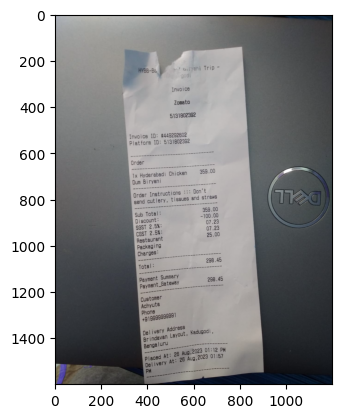

In [ ]:
img_path = "/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg"
result = ocr.ocr(img_path)
save_ocr(img_path, out_path, result, font)

# Laout Parser

In [11]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-l190ptgx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-l190ptgx
  Resolved https://github.com/facebookresearch/detectron2.git to commit 80307d2d5e06f06a8a677cc2653f23a4c56402ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=5738603 sha256=87ac3eba4719fe2e878f34fac67c548a2ba8e8dc33b498d9c5b9fd65eaba65b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xaqpq17y/wheels/47/e5/15/94c80df2ba85500c5d76599cc307c0a7079d0e221bb6fc4375
  Created wheel for fvcore: filename=fvcore-

In [1]:
!pip install layoutparser # Install the base layoutparser library with
!pip install "layoutparser[layoutmodels]" # Install DL layout model toolkit
!pip install "layoutparser[ocr]" # Install OCR toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.5 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=f1b843250fcc64318d617c6370e4756547dfa441234dfe2ff29e0ca36bb43413
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built iopath
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: google-api-core
    Found existing installation: google-api-core 2.11.1
    Uninstalling google-api-core-2.11.1:
      Successfully uninstalled google-api-core-2.11.1


In [20]:
import layoutparser as lp

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2

In [44]:
image = cv2.imread("/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg")
image = image[..., ::-1]
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [45]:
#image
#dir(lp)
#!wget https://www.dropbox.com/s/dgy9c10wykk4lq4/model_final.pth?dl=1

In [46]:
model = lp.models.Detectron2LayoutModel('/content/output/publaynet/faster_rcnn_R_50_FPN_3x/config.yml',
                                        model_path='/content/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
    # Load the deep layout model from the layoutparser API
    # For all the supported model, please check the Model
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [47]:
layout = model.detect(image)
    # Detect the layout of the input image

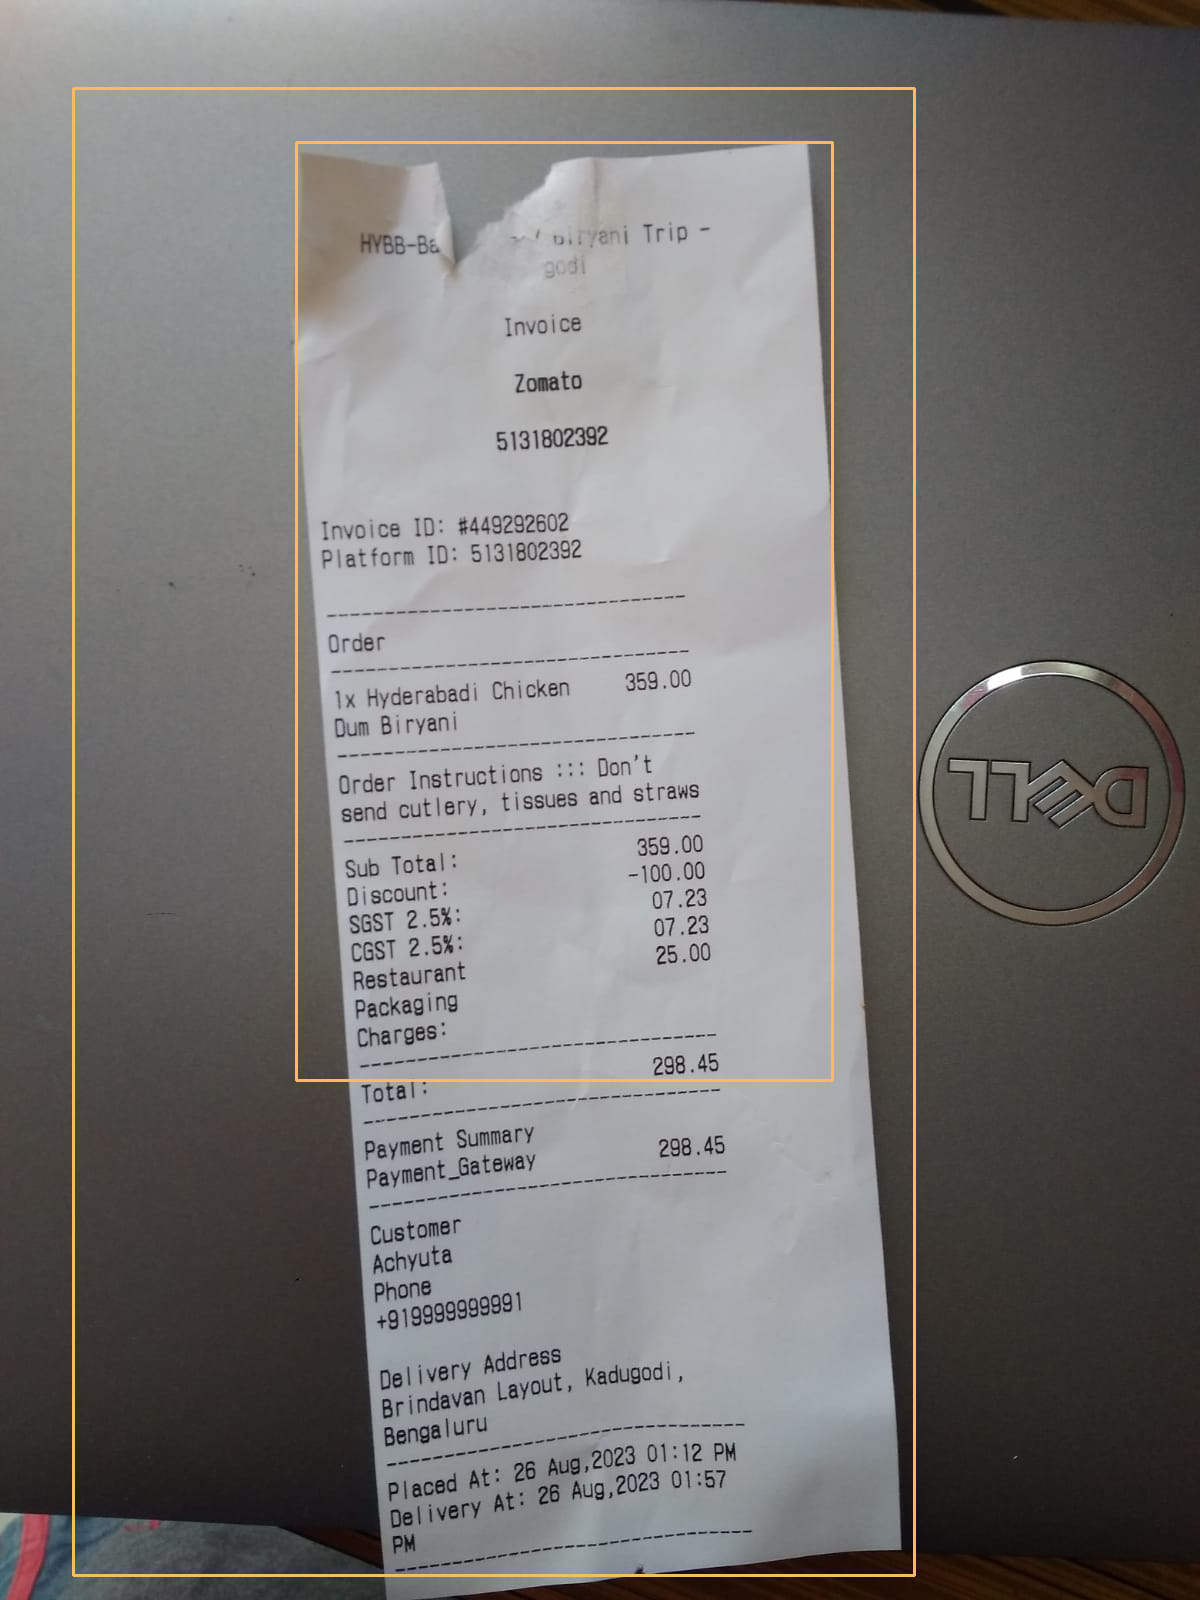

In [48]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

In [49]:
layout[0]

TextBlock(block=Rectangle(x_1=73.66593933105469, y_1=88.05651092529297, x_2=914.9009399414062, y_2=1575.046142578125), text=None, id=None, type=Figure, parent=None, next=None, score=0.9813142418861389)

In [50]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [51]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [52]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

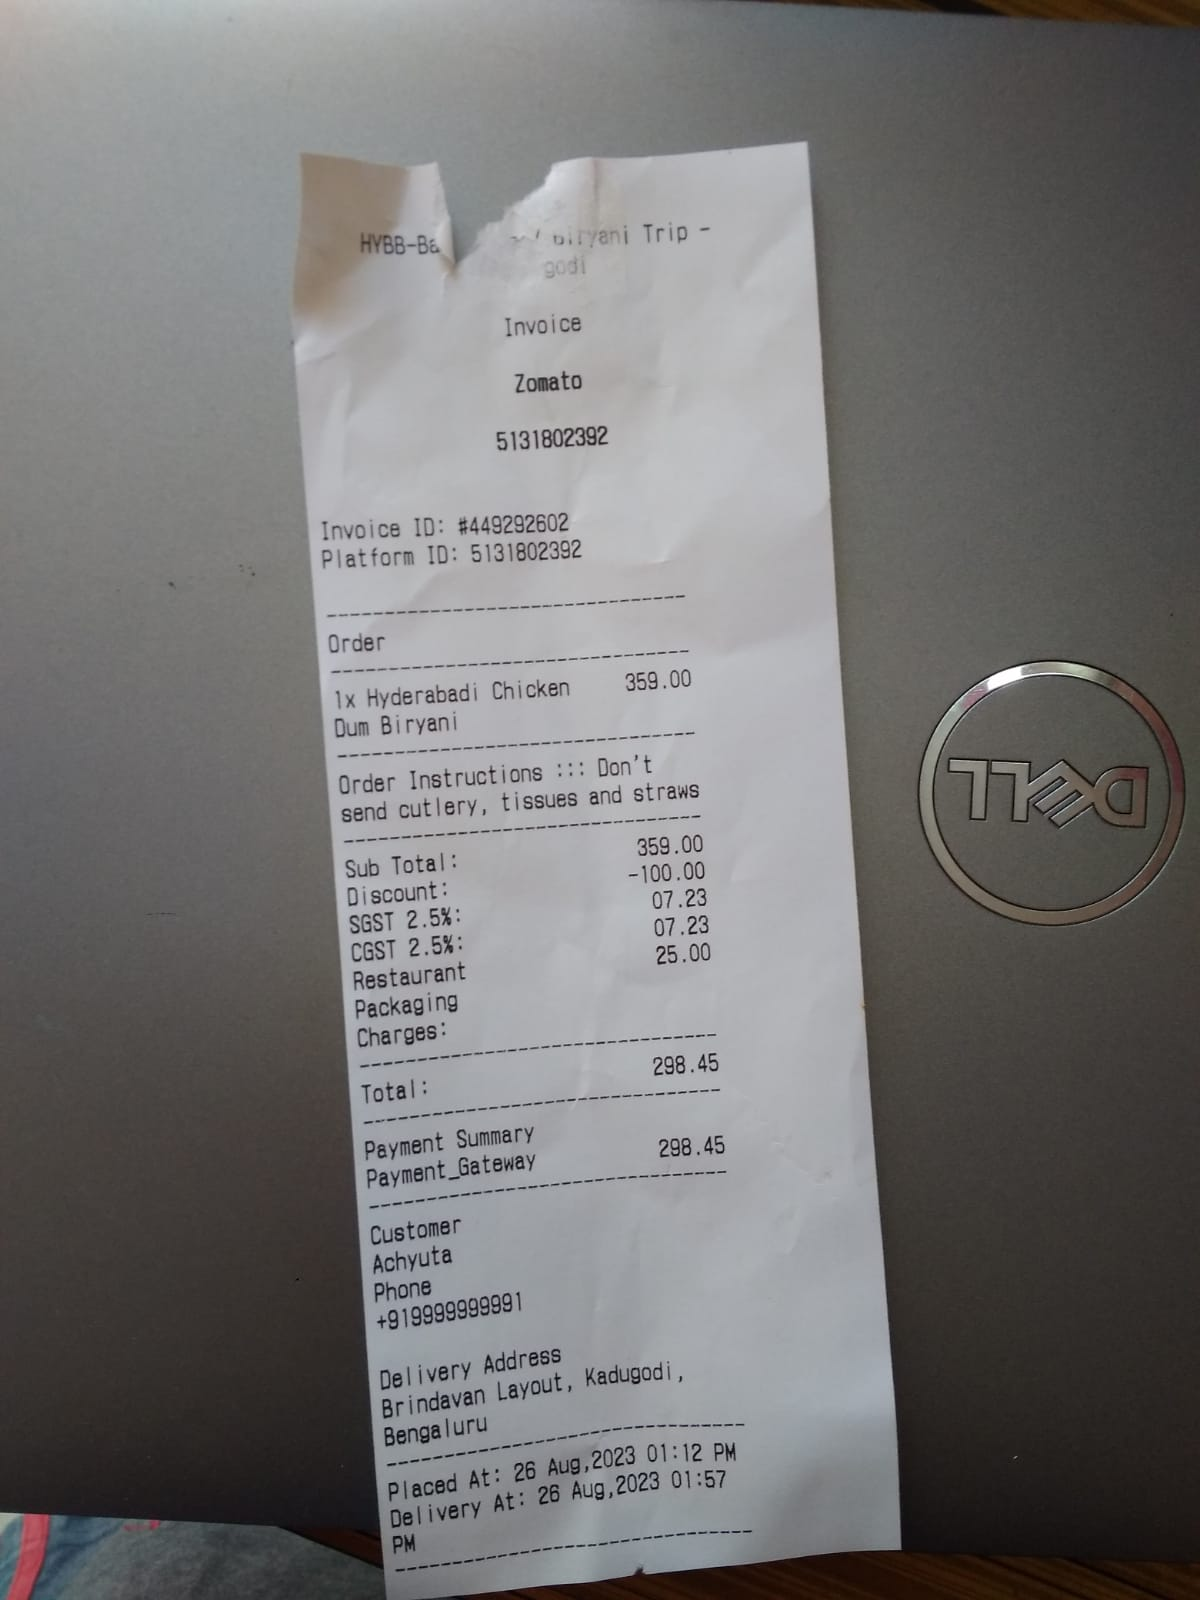

In [53]:
lp.draw_box(image, text_blocks,
            box_width=3,
            show_element_id=True)

In [54]:
ocr_agent = lp.TesseractAgent(languages='eng')
    # Initialize the tesseract ocr engine. You might need
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [55]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [56]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

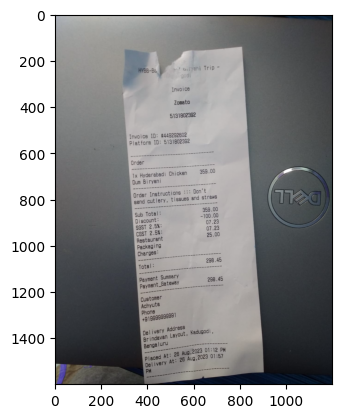

In [30]:
image = cv2.imread('/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg')
plt.imshow(image);


In [31]:
ocr_agent = lp.TesseractAgent(languages='eng')

In [35]:
#!sudo apt-get install tesseract-ocr
dir(ocr_agent)

['DEPENDENCIES',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_detect',
 'configs',
 'detect',
 'gather_data',
 'lang',
 'load_response',
 'save_response',
 'with_tesseract_executable']

In [33]:

res = ocr_agent.detect(image, return_response=True)

# Alternative
# res = ocr_agent.detect('data/example-table.jpeg', return_response=True)

In [39]:
dir(lp.TesseractFeatureType)

['BLOCK',
 'LINE',
 'PAGE',
 'PARA',
 'WORD',
 '__class__',
 '__doc__',
 '__members__',
 '__module__']

In [40]:
texts  = ocr_agent.gather_data(res,lp.TesseractFeatureType.WORD)

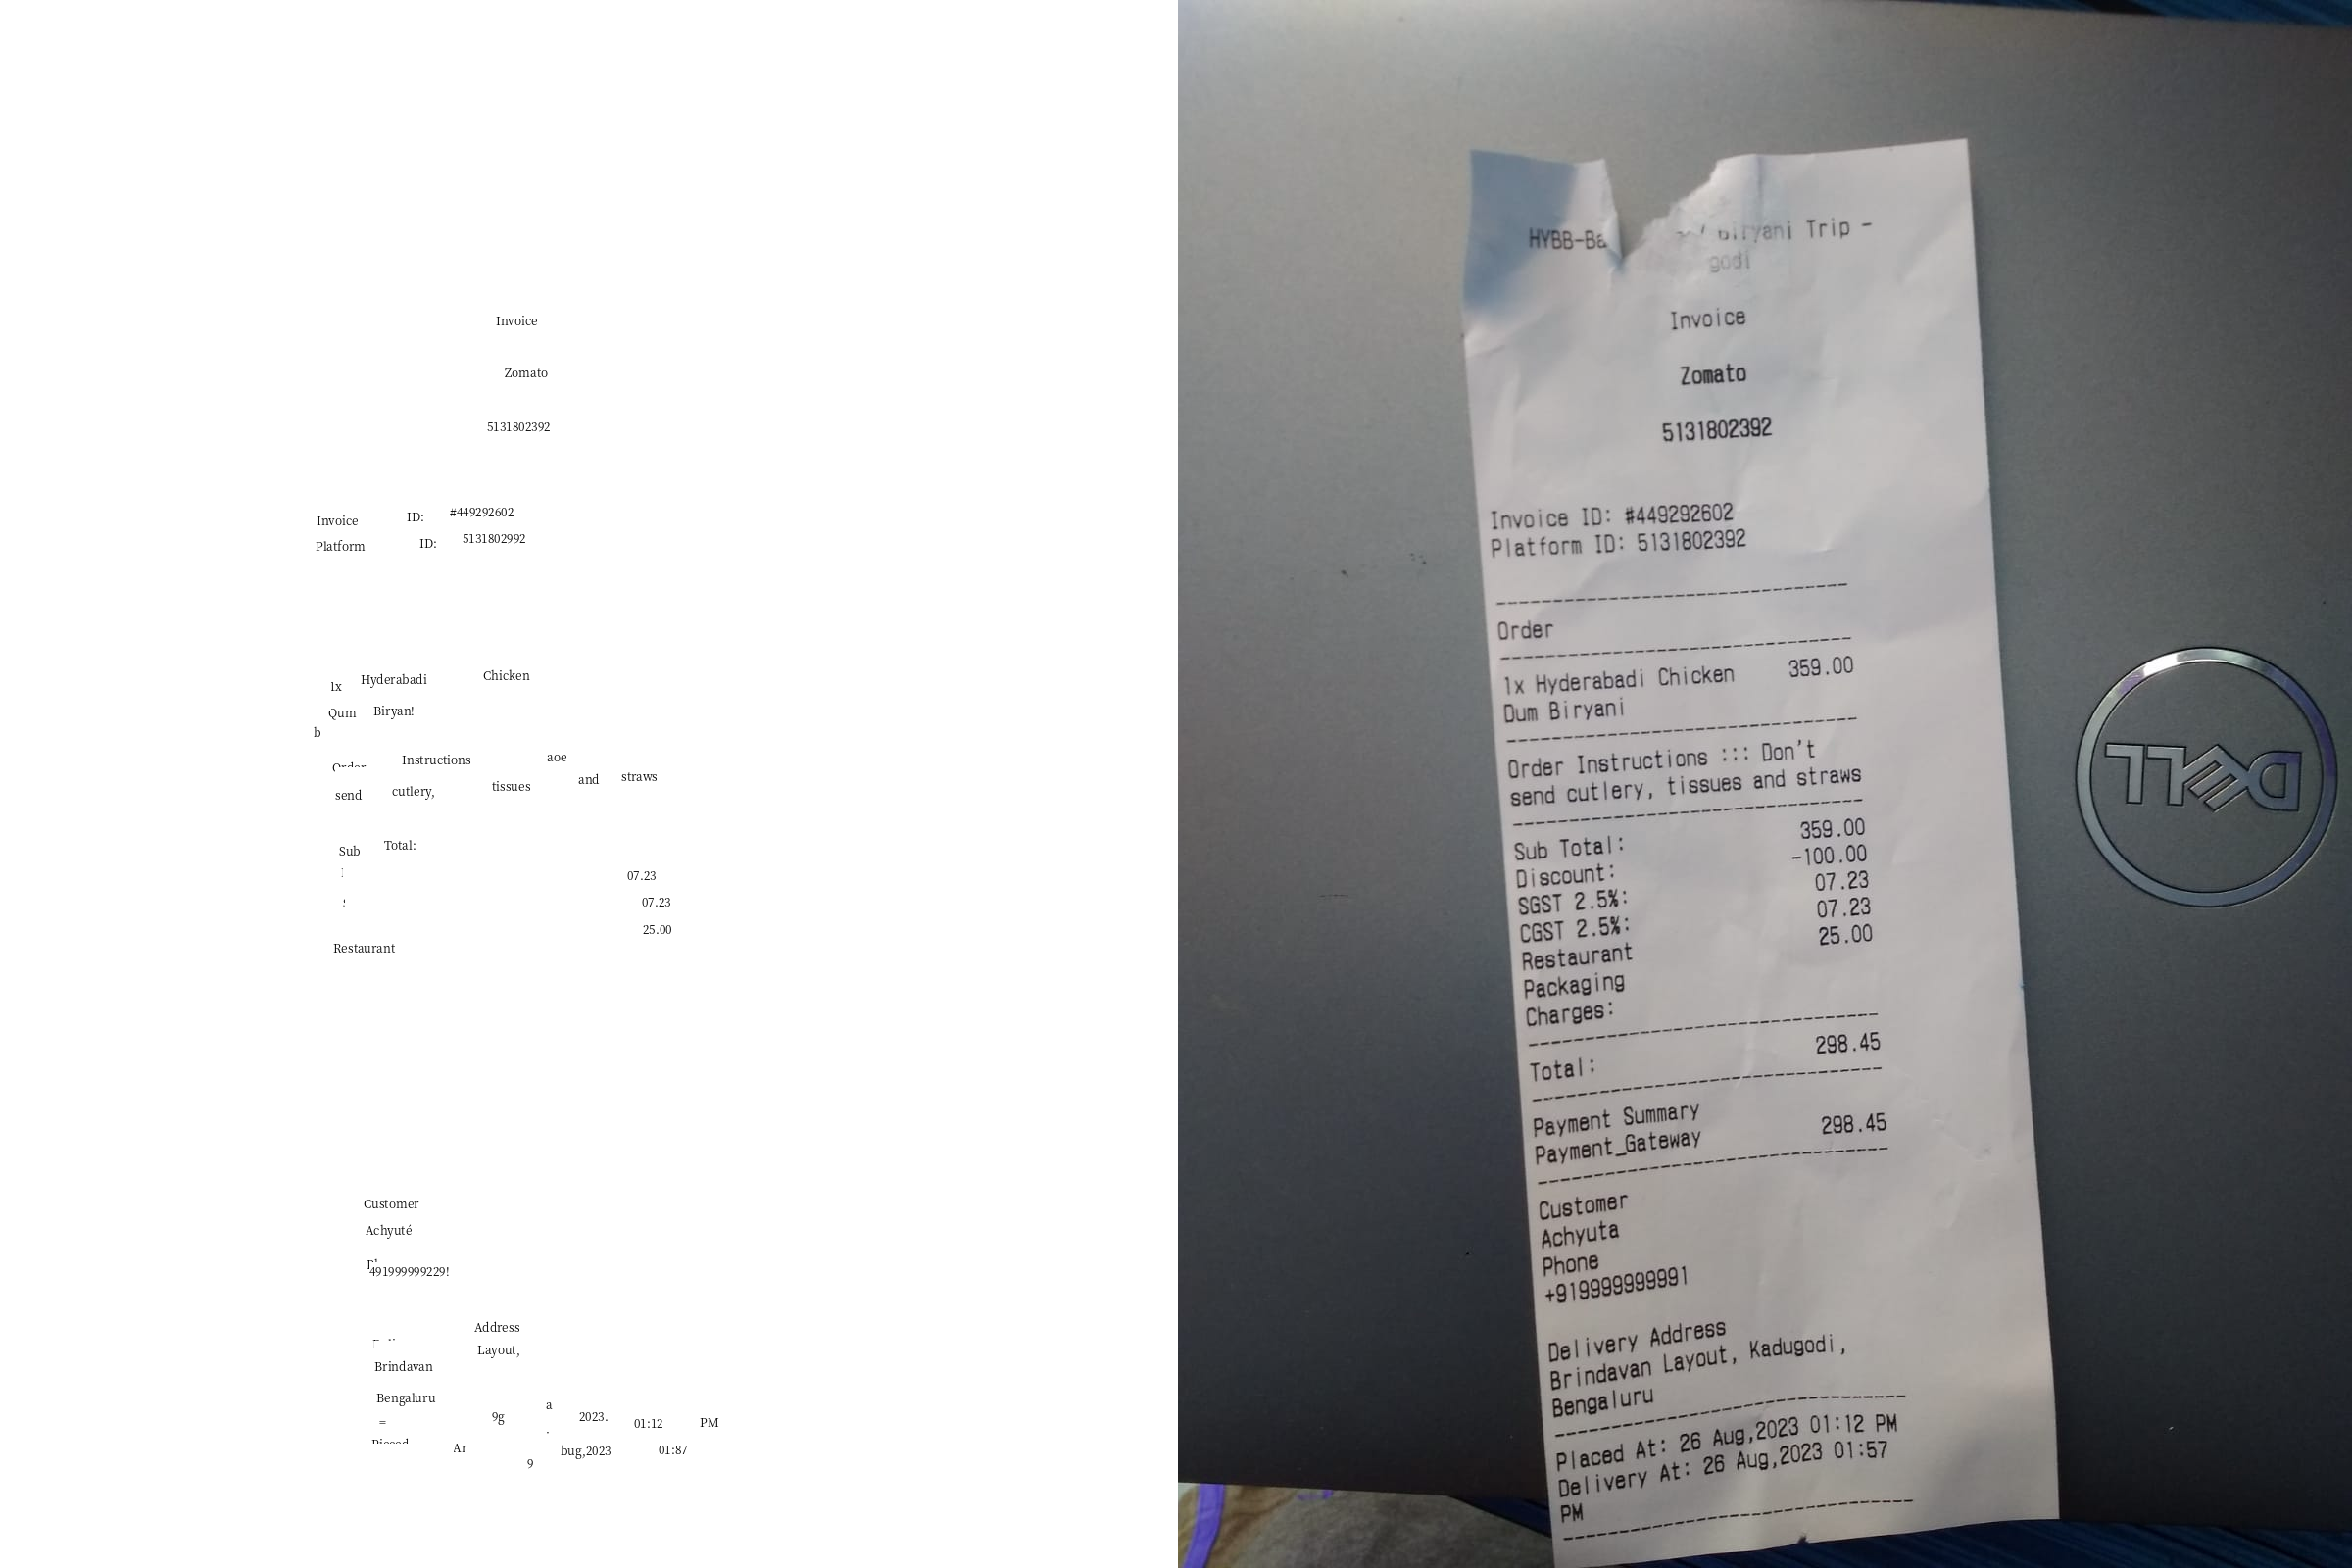

In [41]:
lp.draw_text(image, texts, font_size=12, with_box_on_text=True,
             text_box_width=1)

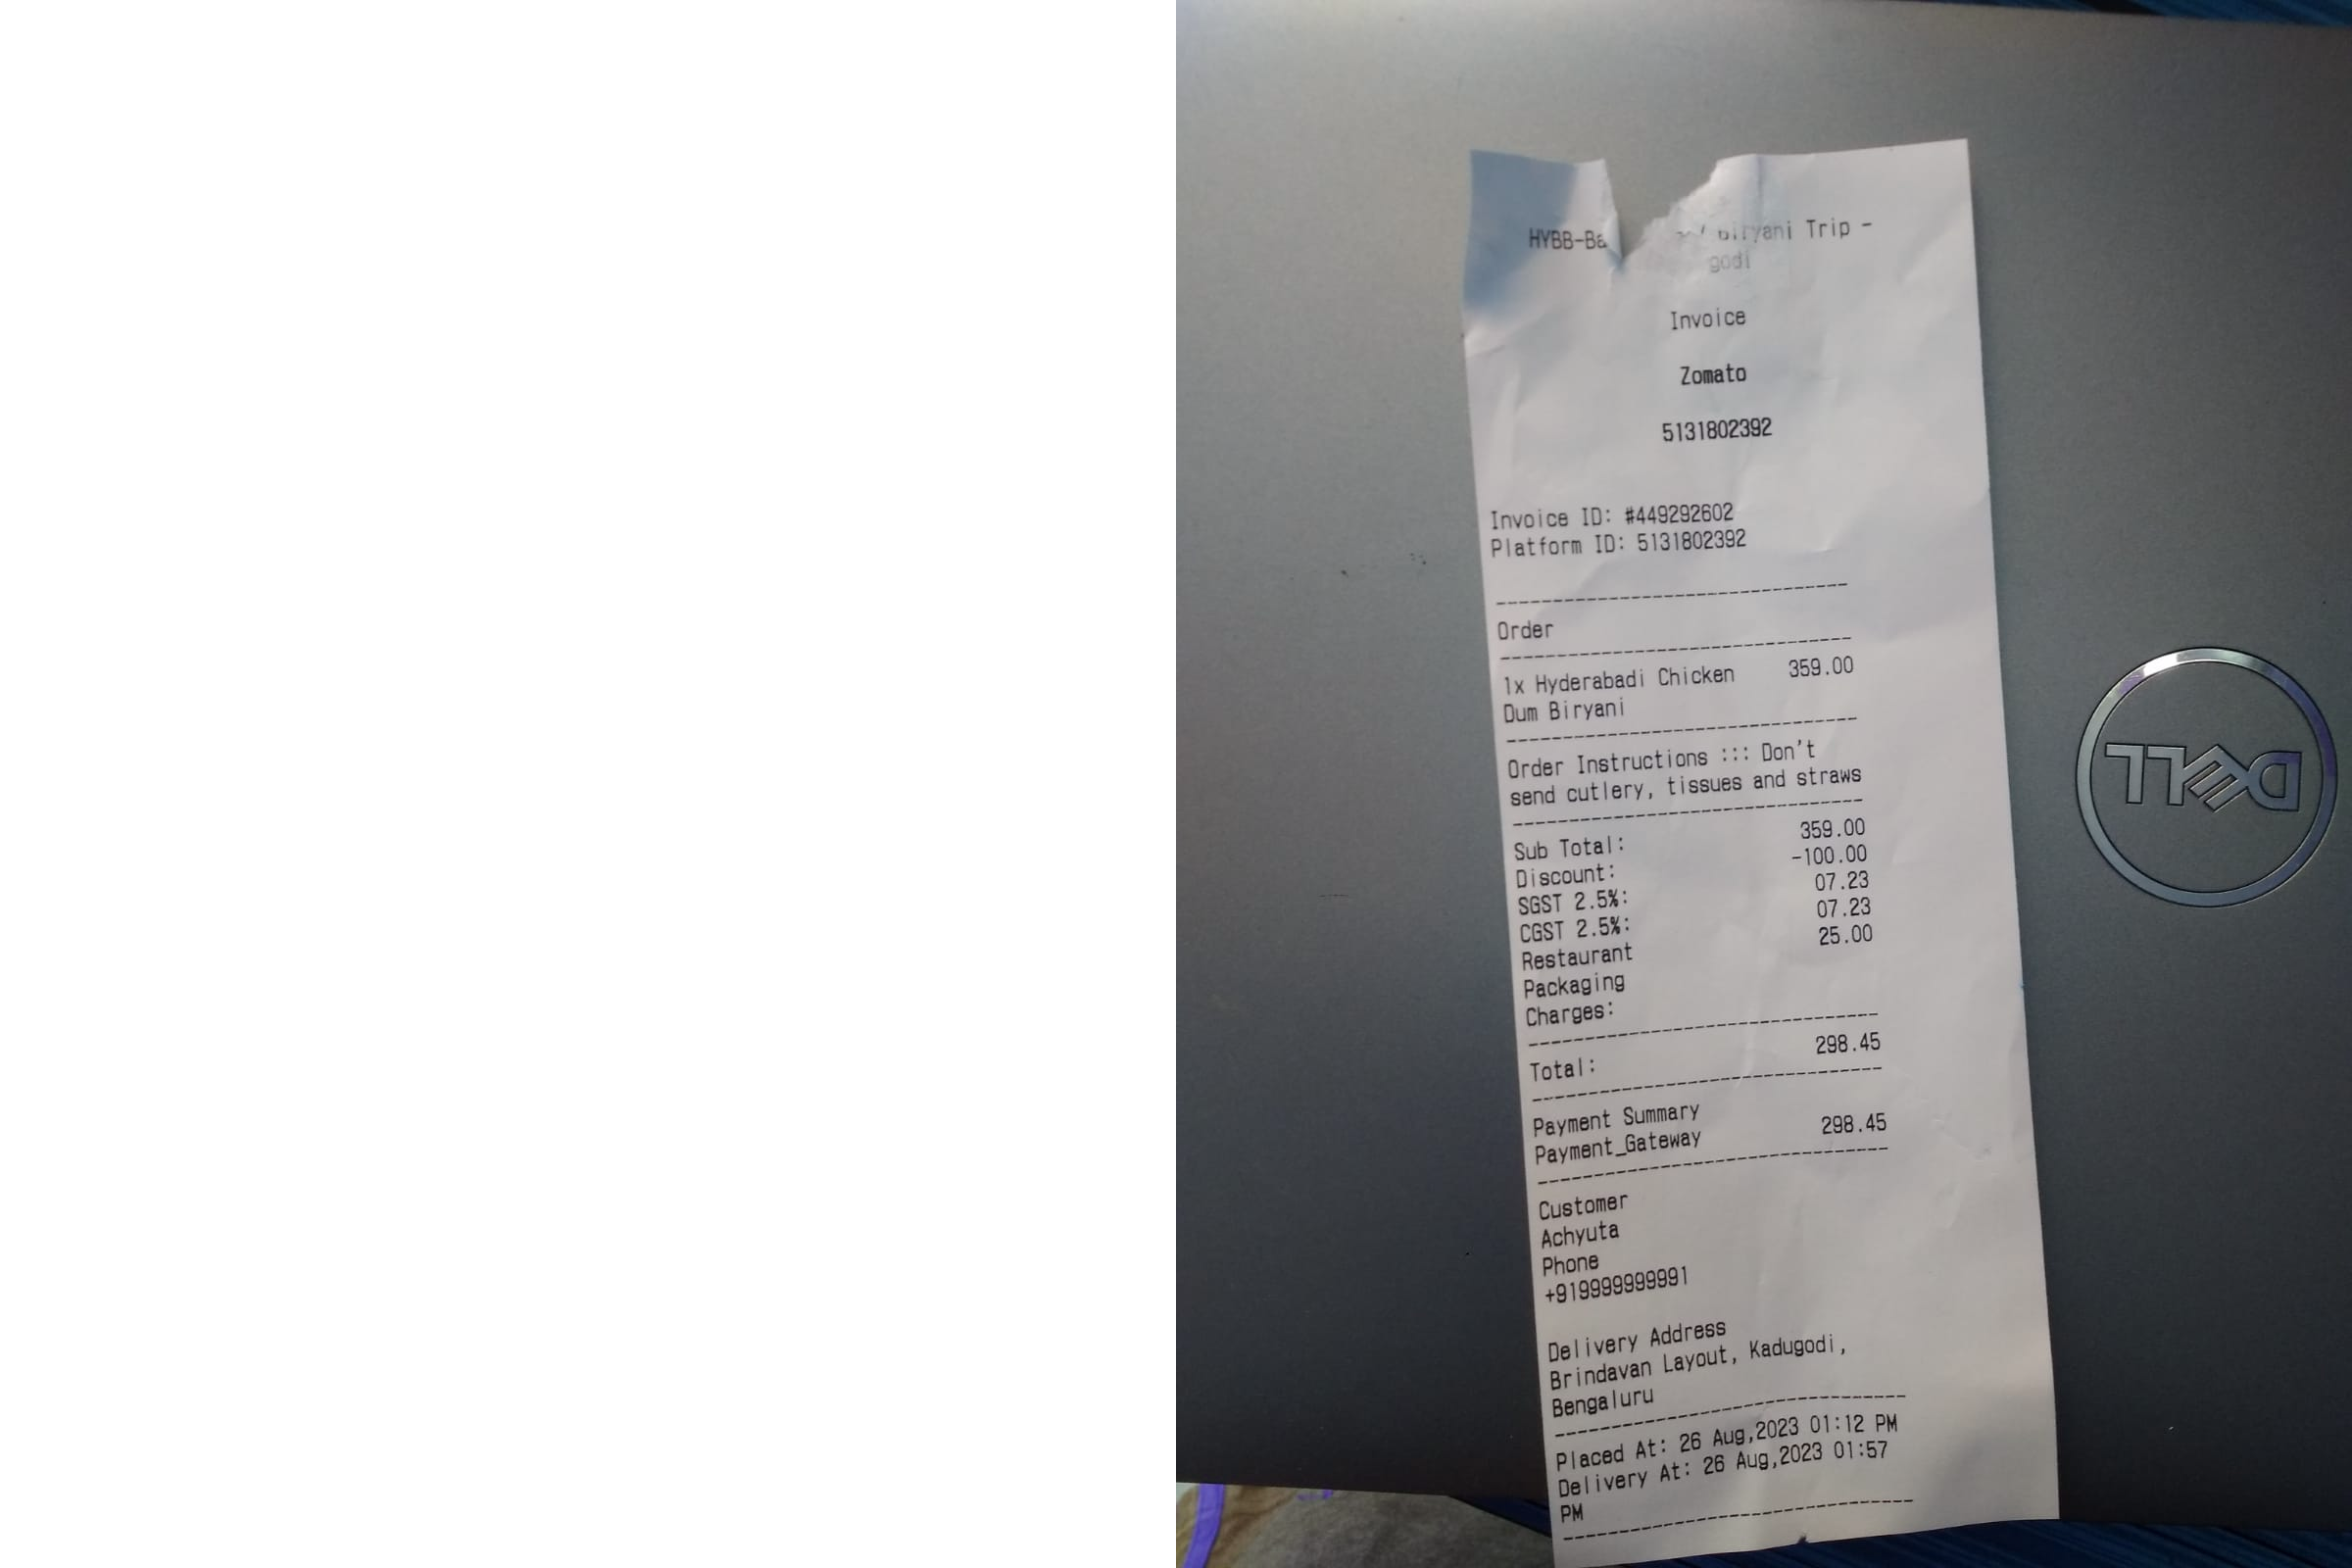

In [42]:
filtered_residence = layout.filter_by(
    lp.Rectangle(x_1=132, y_1=300, x_2=264, y_2=840)
)
lp.draw_text(image, filtered_residence, font_size=16)

In [43]:
texts

Layout(_blocks=[TextBlock(block=Rectangle(x_1=0, y_1=0, x_2=1200, y_2=1600), text=, id=0, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=352, y_1=224, x_2=687, y_2=267), text=, id=1, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=352, y_1=224, x_2=687, y_2=267), text=, id=2, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=352, y_1=224, x_2=687, y_2=267), text=, id=3, type=None, parent=None, next=None, score=-1.0), TextBlock(block=Rectangle(x_1=352, y_1=228, x_2=392, y_2=267), text=RYE, id=4, type=None, parent=None, next=None, score=13.0), TextBlock(block=Rectangle(x_1=404, y_1=236, x_2=439, y_2=254), text=-Be, id=5, type=None, parent=None, next=None, score=21.0), TextBlock(block=Rectangle(x_1=453, y_1=232, x_2=461, y_2=264), text=\, id=6, type=None, parent=None, next=None, score=91.0), TextBlock(block=Rectangle(x_1=554, y_1=236, x_2=563, y_2=244), text=», id=7, type=None, parent=None, next=None,